In [2]:
# Step 1: Load and inspect the data
import pandas as pd

# Load the data from the provided CSV file
file_path = 'aapl.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataframe
df.head()


,Date,Open,High,Low,Close,Volume
0,7/21/2014,94.99,95.00,93.72,93.94,38887700
1,7/18/2014,93.62,94.74,93.02,94.43,49898600
2,7/17/2014,95.03,95.28,92.57,93.09,57152000
3,7/16/2014,96.97,97.10,94.74,94.78,53396300
4,7/15/2014,96.80,96.85,95.03,95.32,45477900


In [9]:
# Step 2: Preprocess the data
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Convert the 'Date' column to datetime format if it's not already
# Replace 'Date' with the actual name of your date column if it's different


# Set the 'Date' as the index


# Consider only the 'Close' price for prediction
data = df[['Close']].values

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Function to create a dataset suitable for LSTM
def create_dataset(data, time_step=60):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

# Prepare the dataset
time_step = 60
X, Y = create_dataset(scaled_data, time_step)

# Reshape X to be [samples, time_steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of Y_test:", Y_test.shape)


Shape of X_train: (2878, 60, 1)
Shape of X_test: (720, 60, 1)
Shape of Y_train: (2878,)
Shape of Y_test: (720,)


In [10]:
# Step 3: Create and train the LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, Y_train, epochs=20, batch_size=64, validation_data=(X_test, Y_test), verbose=1)


Epoch 1/20
45/45 [==============================] - 9s 101ms/step - loss: 0.0123 - val_loss: 3.6500e-04
Epoch 2/20
45/45 [==============================] - 3s 75ms/step - loss: 0.0017 - val_loss: 4.2357e-04
Epoch 3/20
45/45 [==============================] - 5s 112ms/step - loss: 0.0013 - val_loss: 3.1594e-04
Epoch 4/20
45/45 [==============================] - 3s 76ms/step - loss: 0.0014 - val_loss: 4.4504e-04
Epoch 5/20
45/45 [==============================] - 3s 76ms/step - loss: 0.0012 - val_loss: 2.9707e-04
Epoch 6/20
45/45 [==============================] - 3s 76ms/step - loss: 0.0012 - val_loss: 4.6622e-04
Epoch 7/20
45/45 [==============================] - 5s 108ms/step - loss: 0.0011 - val_loss: 2.7462e-04
Epoch 8/20
45/45 [==============================] - 3s 75ms/step - loss: 0.0011 - val_loss: 2.6992e-04
Epoch 9/20
45/45 [==============================] - 4s 85ms/step - loss: 0.0012 - val_loss: 2.8410e-04
Epoch 10/20
45/45 [==============================] - 5s 103ms/step - l

23/23 [==============================] - 1s 29ms/step


ValueError: x and y must have same first dimension, but have shapes (659,) and (720, 1)

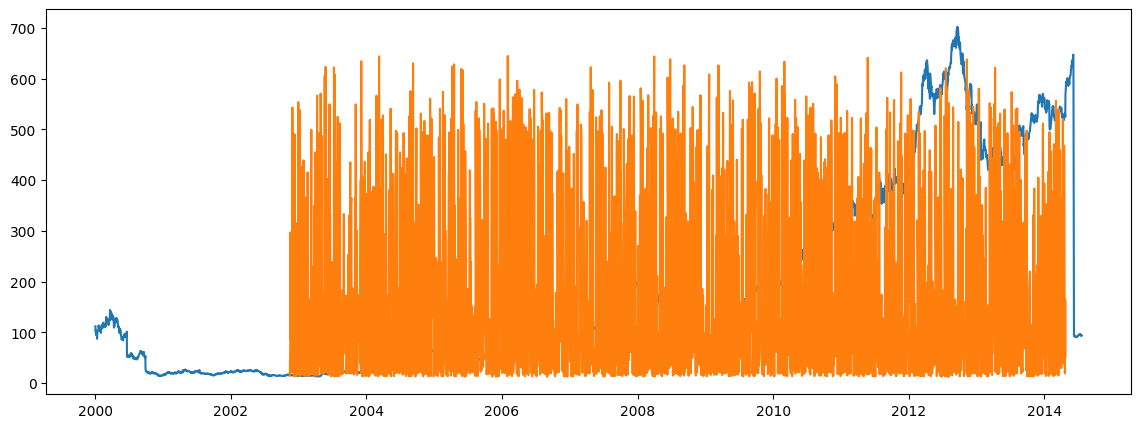

In [12]:
# Step 4: Make predictions and evaluate the model
import matplotlib.pyplot as plt

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the predictions and actual values to get the real values
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
Y_train_actual = scaler.inverse_transform([Y_train])
Y_test_actual = scaler.inverse_transform([Y_test])

# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(df.index, scaler.inverse_transform(scaled_data), label='Actual Price')
plt.plot(df.index[time_step:len(train_predict) + time_step], train_predict, label='Train Predictions')
plt.plot(df.index[len(train_predict) + (time_step*2) + 1: len(scaled_data) - 1], test_predict, label='Test Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

